## **Tarea 3**

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 2.6 K  | train
----------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.011     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
c:\Users\Usuario\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\Usuario\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5725674629211426     │
└───────────────────────────┴───────────────────────────┘

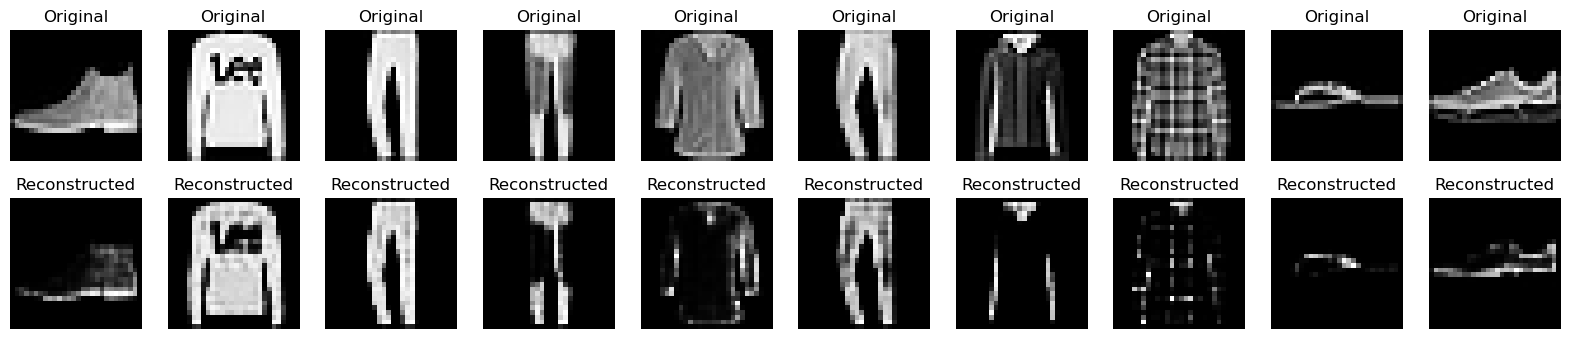

In [26]:
# Importación de todo lo necesario
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
import matplotlib.pyplot as plt
import sys

# Verificar si se está ejecutando dentro de un notebook
def is_notebook() -> bool:
    try:
        return 'ipykernel' in sys.modules 
    except NameError:
        return False  

# Define las transformaciones para el dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar imágenes
])

# Definición del Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),  # Primera capa convolucional
            nn.ReLU(),  # Función de activación ReLU
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1),  # Segunda capa convolucional
            nn.ReLU()  # Función de activación ReLU
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Primera capa deconvolucional
            nn.ReLU(),  # Función de activación ReLU
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Segunda capa deconvolucional
            nn.Sigmoid()  # Sigmoide para restringir los valores entre 0 y 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)  # Codificación la imagen
        decoded = self.decoder(encoded)  # Reconstrucción la imagen desde la representación latente
        return decoded
    
# Definición del módulo Lightning
class LitAutoencoder(pl.LightningModule):
    def __init__(self, config):
        super(LitAutoencoder, self).__init__()
        self.learning_rate = config.model.learning_rate  # Tasa de aprendizaje 
        self.autoencoder = Autoencoder()  # Inicializar el autoencoder

    def forward(self, x):
        return self.autoencoder(x)  # Pasar los datos por el autoencoder

    def training_step(self, batch, batch_idx):
        # Extraer las imágenes del batch
        x, _ = batch

        # Pasar las imágenes por el autoencoder
        x_hat = self(x)

        # Calcular la pérdida (error cuadrático medio entre las imágenes originales y reconstruidas)
        loss = nn.functional.mse_loss(x_hat, x)

        # Registrar el valor de la pérdida
        self.log('train_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        # Extraer las imágenes del batch
        x, _ = batch

        # Pasarlas por el autoencoder
        x_hat = self(x)

        # Calcular la pérdida de prueba
        loss = nn.functional.mse_loss(x_hat, x)

        # Registrar el valor de la pérdida de prueba
        self.log('test_loss', loss)

        # Retornar las imágenes originales y reconstruidas para visualización
        return {"test_loss": loss, "originals": x, "reconstructed": x_hat}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)  
        return optimizer

# Función para graficar las imágenes originales y reconstruidas
def plot_images(originals, reconstructed, n=10):
    """Graficación de las imágenes originales y reconstruidas."""
    plt.figure(figsize=(20, 4)) 
    
    originals = originals[:n].cpu().detach()  # Extraer imágenes originales
    reconstructed = reconstructed[:n].cpu().detach()  # Extraer imágenes reconstruidas
    
    for i in range(n):
        # Graficar las imágenes originales
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i].squeeze(0), cmap='gray')  # Escala de grises (1 canal)
        plt.title("Original")  
        plt.axis("off")  # Ocultar ejes
        
        # Graficar las imágenes reconstruidas
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(0), cmap='gray')  
        plt.title("Reconstrucción")  
        plt.axis("off")  # Ocultar ejes
    
    plt.show()  #Plot

# Función principal para ejecutar el modelo
def main(cfg: DictConfig):
    # Seleccionar dataset según la configuración
    if cfg.dataset.name == 'FashionMNIST':
        dataset_class = datasets.FashionMNIST  #FashionMNIST
    elif cfg.dataset.name == 'MNIST':
        dataset_class = datasets.MNIST  #MNIST
    else:
        raise ValueError(f"El dataset {cfg.dataset.name} no puede ser soportado.")  

    # Cargar dataset con el tamaño de batch 
    train_loader = torch.utils.data.DataLoader(
        dataset_class(root=cfg.dataset.root, train=True, download=True, transform=transform),  
        batch_size=cfg.trainer.batch_size, shuffle=True  # Tamaño de batch y shuffle
    )

    test_loader = torch.utils.data.DataLoader(
        dataset_class(root=cfg.dataset.root, train=False, download=True, transform=transform),  
        batch_size=cfg.trainer.batch_size, shuffle=False  # Tamaño de batch y shuffle
    )

    # Crear al modelo y entrenador
    model = LitAutoencoder(cfg)  
    trainer = pl.Trainer(max_epochs=cfg.trainer.max_epochs)  
    
    trainer.fit(model, train_loader)
    trainer.test(model, test_loader)


    test_batch = next(iter(test_loader))  # Extraer  siguiente batch de prueba
    originals, _ = test_batch  # Extraer imágenes originales

    #Reconstruir las imágenes con el modelo
    reconstructed = model(originals.to(model.device)).cpu().detach()  

    plot_images(originals, reconstructed)#Graficar imagenes

# Adaptado para Jupyter o script normal
if is_notebook():
    # Si es notebook se llama manualmente a Hydra
    cfg = OmegaConf.create({
        'dataset': {
            'name': 'FashionMNIST',  
            'root': './data',  
        },
        'model': {
            'learning_rate': 0.001,  
        },
        'trainer': {
            'batch_size': 64,  
            'max_epochs': 5,  
        }
    })
    main(cfg)  
else:
    # Script de Python regular
    @hydra.main(version_base=None, config_path=".", config_name="config")
    def hydra_main(cfg: DictConfig):
        main(cfg)  

    if __name__ == '__main__':
        hydra_main() 
